# Integrated Hydrology and Reactive Transport

This is a series of problems to test and demonstrate the reactive transport component of ATS in the context of integrated hydrology problems. The focus is thus on the reactive transport component. To learn more about the integrated hydrology, please refer to the integrated hydro demo. 

Tests demonstrate a 1D column (showing dry-to-wet transition with a tracer present in the rainwater that is transported into the subsurface), and a 2D hillslope problem (showing dry-wet cycles driving rainwater infiltration into the subsurface, which in turn drive mineral dissolution, as well as surface runoff, which dilutes the groundwater discharge).

Documentation of this demo is in the early stages of development.

Author: Sergi Molins

In [1]:
import os, sys
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
%matplotlib inline

## Example: 1D infiltration and transport of conservative tracer

In this example, we rain on a column, then turn off the rain.  Initially the column is partially saturated. Over time, the column saturates and ponded water expresses on the surface.  A conservative tracer is present in the rainwater but not in the subsurface initially, thus infiltration of rainwater results in concentrations of the tracer in the subsurface. When water ponds on the surface, the concentration of the tracer in the surface water is that of the rainwater. 

This demonstrates the dry-to-wet transitions and solute mass exchange between surface and subsurface.

In [3]:
# load the ATS solution
directory = ""
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

In [4]:
# load surface solution
vis_surf = ats_xdmf.VisFile(directory, domain='surface')
vis_surf.loadMesh(order=['x','y'])

In [5]:
#get subsurface coord
xsub=vis.centroids[:,2]

#get surface coord
xsurf = vis_surf.centroids[:,0]
xsurf = [10.25]

In [6]:
# settings for plot
SIZE=20
colors=['y','r','b','g','m','k']
cycles=['0','10','18','22','24','34']
#cycles=['0','2','4','8','10','34']

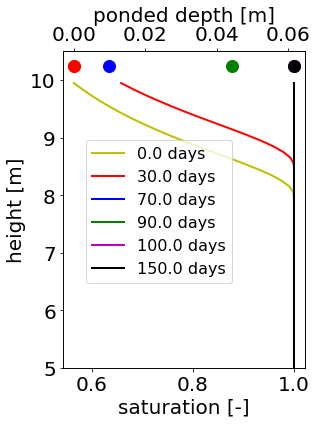

In [7]:
# plot the solution
fig,ax = plt.subplots(figsize=[4.5,6])
bx=ax.twiny()
##plot_column_data.plot_subsurface(vis, ['saturation_liquid',], ax, None, cmap='jet')

for T,c in zip(cycles,colors):
    
    S=vis.get('saturation_liquid',T)
    pd = vis_surf.get('surface-ponded_depth',T)    
    label=str(vis.times[int(T)]*365.25)+' days'
    
    ax.plot(S,xsub,c,linewidth=2,label=label)
    bx.plot(pd,xsurf,c+'o',markersize=12,linewidth=2)
    ax.set_xlabel('saturation [-]',fontsize=SIZE) #,color='g')
    bx.set_xlabel('ponded depth [m]',fontsize=SIZE) #,color='b')
    ax.set_ylabel('height [m]',fontsize=SIZE)
    
ax.tick_params(axis='x', which='major', labelsize=SIZE) #, labelcolor='g')
bx.tick_params(axis='x', which='major', labelsize=SIZE) #, labelcolor='b')

ax.tick_params(axis='y', which='major', labelsize=SIZE)

#ax.set_xlim([0.5,1.02])
#bx.set_xlim([-0.01,0.065])
ax.set_ylim([5,10.5])
fig.tight_layout()
fig.legend(loc='center',fontsize=SIZE*0.8)
fig.savefig('water.png',format='png')

In [8]:
So  = np.array(vis.get('saturation_liquid','0'))
pdn = np.array(vis_surf.get('surface-total_component_concentration.cell.tracer','34')) \
    * np.array(vis.get('molar_density_liquid.cell.0','34')) \
    / np.array(vis.get('mass_density_liquid.cell.0','34'))

mix = (np.ones(len(So)) - So) * pdn

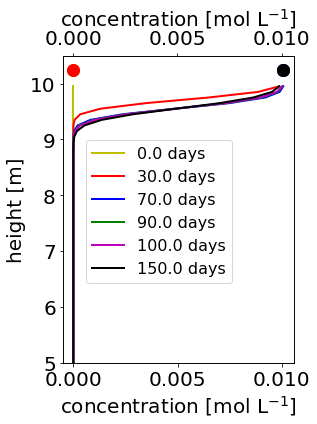

In [9]:
# plot the solution
fig,ax = plt.subplots(figsize=[4.5,6])
bx=ax.twiny()
##plot_column_data.plot_subsurface(vis, ['saturation_liquid',], ax, None, cmap='jet')

for T,c in zip(cycles,colors):
    
    S  = np.array(vis.get('total_component_concentration.cell.tracer',T)) \
       * np.array(vis.get('molar_density_liquid.cell.0',T)) \
       / np.array(vis.get('mass_density_liquid.cell.0',T))
    
    pd = np.array(vis_surf.get('surface-total_component_concentration.cell.tracer',T)) \
       * np.array(vis_surf.get('surface-molar_density_liquid.cell.0',T)) \
       / np.array(vis_surf.get('surface-mass_density_liquid.cell.0',T))
    
    label=str(vis.times[int(T)]*365.25)+' days'
    
    ax.plot(S,xsub,c,linewidth=2,label=label)
    bx.plot(pd,xsurf,c+'o',markersize=12,linewidth=2)    

    ax.set_xlabel(r'concentration [mol L$^{-1}$]',fontsize=SIZE) #,color='g')
    bx.set_xlabel(r'concentration [mol L$^{-1}$]',fontsize=SIZE) #,color='b')

    ax.set_ylabel('height [m]',fontsize=SIZE)
    
    
#ax.plot(mix,xsub,'c'+'--',markersize=12,linewidth=2)

ax.tick_params(axis='x', which='major', labelsize=SIZE) #, labelcolor='g')
bx.tick_params(axis='x', which='major', labelsize=SIZE) #, labelcolor='b')

ax.tick_params(axis='y', which='major', labelsize=SIZE)

#ax.set_xlim([0.5,1.02])
#bx.set_xlim([-0.01,0.065])
ax.set_ylim([5,10.5])
fig.tight_layout()
fig.legend(loc='center',fontsize=SIZE*0.8)
fig.savefig('concentrations.png',format='png')

## Example: 2D hillslope and reactive transport with mineral dissolution

This demo considers a simplified representation of a headwater catchment hillslope. The simulation seeks to capture its hydrological and geochemical response to evolving precipitation inputs over a period of 200 days that include wet and dry periods. Over most of the hillslope rainwater infiltrates into the subsurface, flows downgradient and discharges to the surface near the hillslope toe. During wet periods, groundwater discharge mixes with rain water in this region of the surface. During dry periods, surface water in this region is exclusively from groundwater dicharge.

The geochemical problem considers only the carbonate system with 5 primary species, 6 secondary (equilibrium) complexes, and calcite. Aqueous complexation is considered both in the surface and subsurface domains, while calcite dissolution is considered only in the subsurface domain. Rainwater drives calcite dissolution in the subsurface before it equilibrates at depth. Two non-reactive tracers, one in the subsurface and one in the rainwater, are used to unravel mixing processes.

## Domain and Boundary Conditions

The hillslope is 1000-m long and 45-m deep with an average slope of 0.085

* **Subsurface domain**: The upstream, downstream and bottom boundaries of the subsurface domain are no-flow boundaries. The top boundary is coupled with surface domain. 

* **Surface domain**: Rain is applied as a source terms in the surface flow PK. A free flow (seepage face) boundary condition is set at the hillslope toe.

In [10]:
#figure settings
SIZE=18
mol_to_m3 = 1.8e-5
m3_to_mol = 5.55e4
density = 997.1

#MyFormatter = FuncFormatter(sn.sci_notation)
#path_dat = './dat/'

## Integrated Hydrology

Periodic rainfall is the only source of water in the model, alternating dry with wet cycles with rain of different intensity. Below are the values of recharge applied uniformly on the surface at an observation point.

The flow rate (surface-mass_flux) at the observation point of the hillslope toe (on the surface) shows quick initial drainage, which slows down with time and is followed by subsequent increases in response to precipitation cycles. The hillslope is draining during the entire simulated time.

In the first 50 days, flow is all groundwater as no precipitation is assumed in the simulation.
In the period of 50-75 days when rain starts, flow is a mixing of groundwater and surface water.

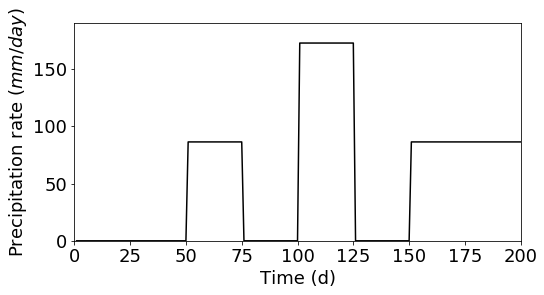

In [11]:
fig, ax = plt.subplots(figsize=(8,4))

rain = np.loadtxt('surface-water_source_sigmoid.dat', skiprows=12)

ax.plot(rain[:,0]/86400, rain[:,1]*86400*1000, 'k-', label='Precipitation')

ax.set_xlabel("Time (d)",fontsize=SIZE)
ax.set_ylabel("Precipitation rate ($mm/day$)",fontsize=SIZE)
ax.set_xticks([0,25,50,75,100,125,150,175,200])

ax.tick_params(axis='both', which='major', labelsize=SIZE)

ax.set_xlim([0,200])
ax.set_ylim([0,190])

#fig.legend(fontsize=12, loc='upper left')
plt.show()

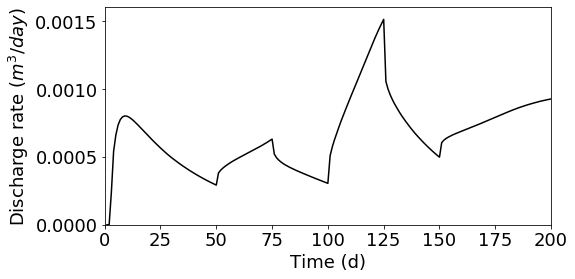

In [12]:
fig, ax = plt.subplots(figsize=(8,4))

discharge = np.loadtxt('surface_outlet_flux_crunch_sigmoid.dat', skiprows=12) 

ax.plot(discharge[:,0]/86400, discharge[:,1]*mol_to_m3, 'k-', label='discharge')

#ax.axes.yaxis.set_major_formatter(MyFormatter)

ax.set_xlabel("Time (d)",fontsize=SIZE)
ax.set_ylabel("Discharge rate ($m^3/day$)",fontsize=SIZE)
ax.set_xticks([0,25,50,75,100,125,150,175,200])

ax.tick_params(axis='both', which='major', labelsize=SIZE)

ax.set_xlim([0,200])
ax.set_ylim([0,1.6e-3])

#fig.legend(fontsize=12, loc='upper left')
plt.show()

## Reactive Transport

We consider transport of 11 species, of which 5 are primary and 6 secondary. Only total component concentrations are transported by ATS, thus must be specified in each of the Transport PKs, with the same name and in the same order as the primary species in the geochemical engine. For example, for subsurface transport. Calcite is the only mineral considered.

## Sources and ICs for transport

The only external **source** of solutes is in the rain water. As with the surface flow problem, in the surface transport PK, a source term of solutes must specified in the surface. Here it is done as a geochemical condition named **rain**. The condition name must match the one available in the engine's input file (it is case-sensitive). Rainwater is equlibrated with atmospheric CO2.

We use the initial conditions in chemistry PKs to specify the presence (subsurface) or absence (surface) of calcite. This is done in the engine input file, where the volume fraction and surface area are specified. For example, the initial condition in the subsurface is named **initial**, and in the surface is named **surfini**.

## Geochemical exports

The concentration breakthrough curves are evaluated at the hillslope toe on the surface. The effluent chemical exports present the mixing processes and calcite reaction simulated within the hillslope domain.

Key points:

- Tracer2 has the same initial and boundary conditions as Ca++, therefore, the difference between Tracer2 and Ca++ is due to calcite reaction

- Solute concentration (except Tracer1) decrease when recharge period starts, because their concentrations are low in the rain water thus mixing with groundwater in the discharge at the hillslope toe. Tracer1 is high in the rain water thus its concentration increases when recharge period starts.

In [13]:
#total = np.loadtxt('surface_total_concentration_crunch_sigmoid.dat', skiprows=12) 
#primary = np.loadtxt('surface_free_ion_species_crunch_sigmoid.dat', skiprows=12)

#for now this is hardwired to visit pick output-- Needs to be updated
curves='curve/'

total_Ca = np.loadtxt(curves+'total_Ca.curve', skiprows=1) 
total_HCO3 = np.loadtxt(curves+'total_HCO3.curve', skiprows=1) 
total_H = np.loadtxt(curves+'total_H+.curve', skiprows=1) 
total_Tracer1 = np.loadtxt(curves+'total_Tracer1.curve', skiprows=1) 
total_Tracer2 = np.loadtxt(curves+'total_Tracer2.curve', skiprows=1) 
#primary = np.loadtxt('surface_free_ion_species_crunch_sigmoid.dat', skiprows=12)

threshold = 3e-5

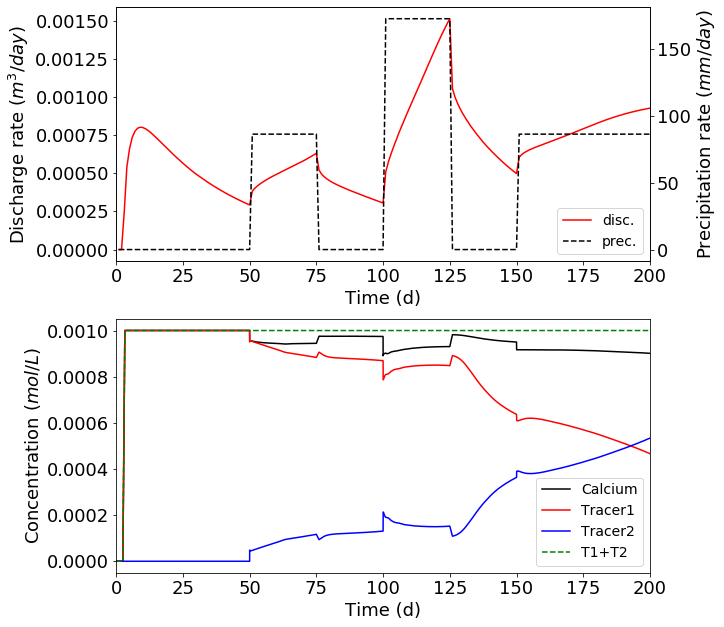

In [14]:
fig, ax = plt.subplots(2, 1,figsize=(10,9))

# top
bx = ax[0].twinx()

p1 = ax[0].plot(discharge[:,0]/86400, discharge[:,1]*mol_to_m3, 'r-', label='disc.')
ax[0].set_xlabel("Time (d)",fontsize=SIZE)
ax[0].set_ylabel("Discharge rate ($m^3/day$)",fontsize=SIZE)

ax[0].set_xticks([0,25,50,75,100,125,150,175,200])
ax[0].set_xlim([0,200])
ax[0].tick_params(axis='both', which='major', labelsize=SIZE)

#ax[0].axes.yaxis.set_major_formatter(MyFormatter)

p2 = bx.plot(rain[:,0]/86400, rain[:,1]*86400*1000, 'k--', label='prec.')

bx.set_ylabel("Precipitation rate ($mm/day$)",fontsize=SIZE)
bx.tick_params(axis='both', which='major', labelsize=SIZE)

px=p1+p2
lpx = [l.get_label() for l in px]
ax[0].legend(px,lpx,fontsize=14, loc='lower right')

#.set_xlabel("Time (d)",fontsize=SIZE)
#ax[0][1].set_xticks([0,25,50,75,100,125,150,175,200])
#ax[0][1].set_xlim([0,200])

# bottom
h1=ax[1].plot(365.25*total_Ca[:,0][total_Ca[:,1]<threshold], m3_to_mol/density*total_Ca[:,1][total_Ca[:,1]<threshold], 'k-', label='Calcium')
h2=ax[1].plot(365.25*total_Tracer1[:,0][total_Ca[:,1]<threshold], m3_to_mol/density*total_Tracer1[:,1][total_Ca[:,1]<threshold], 'r-', label='Tracer1')
h3=ax[1].plot(365.25*total_Tracer2[:,0][total_Ca[:,1]<threshold], m3_to_mol/density*total_Tracer2[:,1][total_Ca[:,1]<threshold], 'b-', label='Tracer2')

h4=ax[1].plot(365.25*(total_Tracer1[:,0])[total_Ca[:,1]<threshold], \
              m3_to_mol/density*(total_Tracer1[:,1]+total_Tracer2[:,1])[total_Ca[:,1]<threshold], \
              'g--', label='T1+T2')


hx=h1+h2+h3+h4
lhx = [l.get_label() for l in hx]
ax[1].legend(hx,lhx,fontsize=14, loc='lower right')

#ax[1].axes.yaxis.set_major_formatter(MyFormatter)
ax[1].set_xlabel("Time (d)",fontsize=SIZE)
ax[1].set_ylabel("Concentration ($mol/L$)",fontsize=SIZE)
ax[1].set_xticks([0,25,50,75,100,125,150,175,200])
ax[1].set_xlim([0,200])
ax[1].tick_params(axis='both', which='major', labelsize=SIZE)

#ax.set_ylim([0,1e-3])
#ax[0][0].tick_params(axis='both', which='major', labelsize=SIZE)


fig.tight_layout()
fig.savefig('hillslope-outlet.png',format='png')
plt.show()